<a href="https://colab.research.google.com/gist/GubioGL/2cb791a72a3dea154008232bfe8121fc/mestrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install --upgrade LightPipes

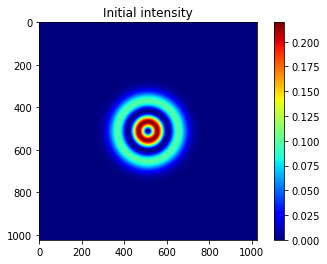

In [13]:
from LightPipes import *
from matplotlib import image
from scipy.fft import fft2, ifft2 ,fftshift
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy


### Propriedade do laser e constantes  ####################################

P = 1 # ordem do polinômio 
L = 1
n = 2**10 + 1
lamb = 512*nm         # Estamos considerando a dimensao em [nm]
k = 2*np.pi/lamb         # Vetor de onda 
w_0 = 1.6*mm          # Raio da cintura do feixe [mm]
z_R = np.pi*w_0**2/lamb # 56mm O intervalo ou comprimento de Rayleigh z_R é determinado dado um tamanho à cintura do feixe gaussiano

## UTILIZEI O DADOS :Experimental synthesis of partially coherent beam with controllable twist phase and
## measuring its orbital angular momentum


### Definindo a rede espacial(Vetores) ###############################################

dx = 17*um  # um
x = np.arange(-n/2+1, n/2,1)*dx
y = np.arange(-n/2+1, n/2,1)*dx
xx,yy = np.meshgrid(x,y)

### Distância máxima de propagação #######################
zmax = 2*n*dx**2/(lamb)
### Eixo de propagação ###################################

dzPar = np.arange(1e-20,10,1)*cm   # Estamos multiplicando por 1*10^9, pois temos 8[nm] e desejamos 8[m]=8x10^9[nm]
z = dzPar[0]       # Representa o eixo z

### Onda de entrada(mask): Campo diretamente após o SLM ######
r    = np.sqrt(xx**2+yy**2)                                                 # Variavel Raio
C    = np.sqrt(2*np.math.factorial(P)/(np.pi*np.math.factorial(P+abs(L))))  # Constante de Normalização
w    = w_0*np.sqrt(1+(z/z_R)**2)                                            # Raio da cintura do feixe em z 
R    = z*(1+(z_R/z)**2)                                                     #Raio de curvatura 
phi  = (1+2*P+abs(L))*np.arctan(z/z_R)                                      # Fase de gouy
PL   = scipy.special.assoc_laguerre(2*r**2/w**2,P,abs(L))                   #Primeira entrada é a variavel"x", Segunda-> graul;Terceira-> Ordem
Fase = np.exp(-r**2/w**2 - 1j*k*r**2/(2*R) + 1j*phi - 1j*L*np.arctan2(yy,xx))*np.exp(-1j*k*z)

LG = C*w_0/w*(r*np.sqrt(2)/w)**abs(L)*PL*Fase

# Inicialização do objeto "campo" na simulação (uma classe de objetos do pacote LightPipes)
F = Begin(2*abs(x[1]),lamb,n);

FinL = F.copy(F)
FinL.field = LG

# Mostrando os campos

img=Intensity(0,FinL);      # intensidade do campo
plt.imshow(img,cmap='jet'); plt.title('Initial intensity')
plt.colorbar()
plt.show()


In [14]:
#Pedidno permissão para ter acesso ao drive
from google.colab import drive
drive.mount('/content/drive', True)
# Aqui estou chamando o arquivo(Que está no drive) com o pacote PIL e salvando como SLM, 
import PIL
from PIL import Image
# note que ainda é uma imagem, para convertem em dados temos que fazer os passo seguintes 
SLM  = Image.open('/content/drive/MyDrive/Colab Notebooks/Gubio/1024.png')
#SLMC = Image.open('/content/drive/MyDrive/Colab Notebooks/Gubio/cir.png')

Mounted at /content/drive


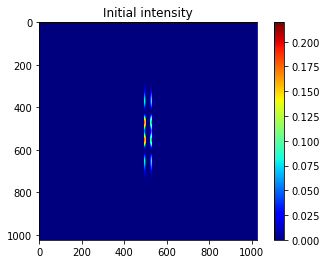

In [15]:
### Mascara da dupla fenda ###################################
### Processamento da imagem na fomra binaria 
imgGray = SLM.convert('L')
imgGray.save('imgGray2.jpg')

imgGra  = plt.imread('imgGray2.jpg')
ri = imgGra/imgGra.max()

EE = FinL.field*ri

Fin2 = F.copy(F)
Fin2.field = EE

# Mostrando os campos

img=Intensity(0,Fin2);      # intensidade do campo
plt.imshow(img,cmap='jet'); plt.title('Initial intensity')
plt.colorbar()
plt.show()

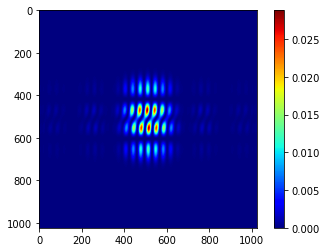

In [16]:
propagação = Forvard(60*cm,Fin2) # VALORES MENOS QUE 3 E MAIOR QUE 6 TEM MUITO RUIDO 
imagem = Intensity(0,propagação)

plt.imshow(imagem,cmap='jet'); 
plt.colorbar()
plt.show()

In [17]:
### Função da Suavização #########################
def SUAVE(media, linha):
  novalista = []
  for i in range(media ,1024,1):
    b = imagem[linha,i-media:i]
    AA = sum(b)/media
    novalista.append(AA)
  return np.array(novalista)

def MM(suavizar,linha):

  # Vamos encontrar o valor no qual temos máximo:
  maxi2 = SUAVE(suavizar,linha).max()
  # Vamos encontrar o posição no qual temos máximo:
  posiçao2 = 0
  for i in SUAVE(suavizar,linha):
    if i == maxi2:
      #print('Jarvis - Sr. A posiçao do valor maximo é = ', posiçao2)
      break 
    posiçao2 +=1 
  # Encontrar o valor mínimo local a parti do maximo Global
  mini = 0
  Vimax = SUAVE(suavizar,linha)[posiçao2:1024]
  for i in range(len(Vimax)):
    if Vimax[i] > Vimax[i+1]:
      mini = Vimax[i+1]
    elif Vimax[i] < Vimax[i+1]:
      mini = Vimax[i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMin = 0 
  for i in Vimax:
    if i == mini:
      break 
    PMin += 1  
  posiçaomin = posiçao2 + PMin -1
  # [0] = Valor max,[1] = Posição max ,[2] = Valor Min,[3] = Posição Min
  return maxi2, posiçao2, mini, posiçaomin  

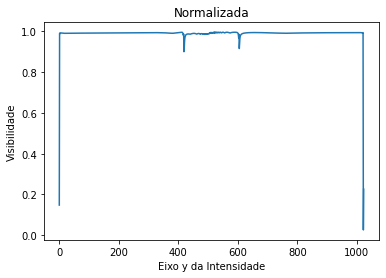

In [18]:
# A VISIBILIDADE TODA
VisibilidadeN = []

for j in range(0,1024):
  V = ( MM(2,j)[0]  - MM(2,j)[2] )/( MM(2,j)[0]  + MM(2,j)[2])
  VisibilidadeN.append(V) 
  
plt.plot(VisibilidadeN) 
plt.title("Normalizada")
plt.xlabel('Eixo y da Intensidade')
plt.ylabel("Visibilidade")
plt.show()


(0.00744920820960499, 528, 3.5283219809801173e-05, 545)


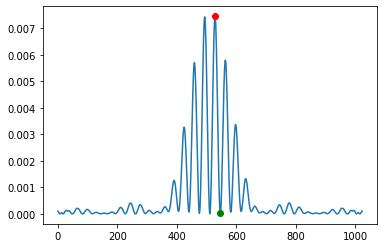

Visibilidade = 0.9905716453435608


In [19]:
qe =2
qw = 512
print(MM(qe,qw))

# DISTRIBUIÇÃO DE INTENSIDADE

plt.plot(imagem[qw])
plt.plot(MM(qe,qw)[1] , MM(qe,qw)[0] , 'o', color ='red'  )
plt.plot(MM(qe,qw)[3] , MM(qe,qw)[2] , 'o', color ='green'  )
plt.show()

# VISIBILIDADE

V = ( MM(2,qw)[0]  - MM(2,qw)[2] )/( MM(2,qw)[0]  + MM(2,qw)[2])
print("Visibilidade =",V)

In [20]:
delta = 5*mm # comprimento de coerencia do feixe
xx1 = 2*cm
xx2= 2.04*cm

mi = np.exp( - abs(xx2-xx1)**2/(2*delta**2)  )
print("DOC =",mi)

DOC = 0.9968051145430329


In [22]:
#Comferindo as medidas
print('Comprimento de onda',lamb)
print('Cintura',w_0)
print('Comprimento do pixel',dx)
#print('comprimento de Rayleigh',z_R)
print('k=',k)
print("Distância máxima de propagação =", zmax)
print("Comprimento de coerencia do feixe =", delta)
print("Distancia da Fendas(DOC) =",xx2-xx1)

Comprimento de onda 5.12e-07
Cintura 0.0016
Comprimento do pixel 1.7e-05
k= 12271846.303085128
Distância máxima de propagação = 1.1571289062499999
Comprimento de coerencia do feixe = 0.005
Distancia da Fendas(DOC) = 0.00040000000000000105
